In [ ]:
import pandas as pd
import numpy as np
import json
import ast
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

df = pd.read_csv('played_out.csv', index_col=0)

## All possible cotegories : 2 x 3 x 5 = 30
df['cat'] = df['gender'] + '_' + df['age'].astype(str) + '_' + df['first_genre'].astype(str)

# Number of unique users per category
df.groupby(['gender', 'age', 'first_genre']).agg({'user':pd.Series.nunique}).reset_index()


,gender,age,first_genre,user
0,F,20,1,3
1,F,20,2,3
2,F,20,3,3
3,F,20,4,3
4,F,20,5,3
5,F,40,1,3
6,F,40,2,3
7,F,40,3,4
8,F,40,4,3
9,F,40,5,3


## 4 different users with same tracks + played_at 

### Moreover, 2 participants with the same songs' playlist

In [ ]:
# Consider the data set only for non-seed songs
only_correct = df[df['position'] > 1].copy() #  4572 - 4394 = 178

# Covert ISO8601 to panda datetime64 
# 2025-12-16T16:46:00.424Z to 2025-12-16 16:46:00.424000+00:00
only_correct['played_at'] = pd.to_datetime(only_correct['played_at'], format='ISO8601')

# datetime objects back to strings i.e to 2025-12-16 16:46:00
only_correct['played_at'] = only_correct['played_at'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Groups rows where the same track was played at the exact same timestamp
# For each unique (timestamp, track) combo,
duplicates = only_correct.groupby(['played_at', 'track.id'])['user'].agg(
    user_count='nunique', # No. of unique users who played this track at this exact time
    user_list=lambda x: list(set(list(x))) #List of those unique user IDs (deduplicated)
) # 3949 x 2

# # exactly 4 distinct users played the same track at the same time
all_files = duplicates[duplicates['user_count'] == 4].reset_index(drop=True) # 98
# There are 98 songs played by the 4 differnt users at the same time.

# Union of all 98 users list
all_files_users = set(all_files.user_list.sum())
all_files_users # users who played same song at the same time


# There are 8 users played the same songs at the same time.
# Morever, 2 paricipants have played the same songs at the same time

{'19befa2d20a544b3819a1236cf7536c4_Harsh1',
 '48ff0874c22542e48ae7bb2b43f708be_Harsh2',
 'b3a05964788f4433a57a6113f54418e2_AnirudhParameswaran',
 'b5890668a00444daad40dd33ab28f9c0_AnirudhParameswaran',
 'cff6b6a2d3d44bb7be43ac90cc6283b3_Harsh4',
 'd5d9baabb48d4c09959ab4abef8cb54a_AnirudhParameswaran',
 'e6a6cc7b1aa84cf28e6b2b3d475bfe40_AnirudhParameswaran',
 'f131564c8f17444c8e0dd7274c994ddc_Harshh3'}

In [ ]:
set(duplicates[duplicates['user_count'] > 1].reset_index(drop=True).user_list.sum())
# There are 16 users in total who are having duplicate playlist among them

# Out of which 2 participants (Harsha, Anirudh) were from group 1, so total 8 users

# Set difference
set(duplicates[duplicates['user_count'] > 1].reset_index(drop=True).user_list.sum()) - set(duplicates[duplicates['user_count'] == 4].reset_index(drop=True).user_list.sum())



{'24bebb12512f476a8e08b14a1aaa08ea_Hannah',
 '3c2742f8ee5b44b2bdeda3778259a80b_Maike',
 '65cbd7ca2e8f4589bb9edc3d8319f73d_Jay',
 'af56d3b2b90948fc9306ba75d3304a55_Andy',
 'b32e896539eb4b25856361076a3d14c1_Daniel',
 'd78a185d41ba4097b0601c57ca3dcfd0_Thomas',
 'e08842478de84103a789b03eb2e48b2a_Maike',
 'e873f35842484d38b61cbd8d81f02f66_Hannah'}

## 2 different users with same tracks + played_at

In [129]:
two_files = duplicates[duplicates['user_count'] == 2].reset_index(drop=True)
two_files_users = set(two_files.user_list.sum())
split = pd.DataFrame(two_files['user_list'].to_list(), columns=['user1', 'user2']).drop_duplicates().reset_index(drop=True)
split

,user1,user2
0,3c2742f8ee5b44b2bdeda3778259a80b_Maike,e08842478de84103a789b03eb2e48b2a_Maike
1,24bebb12512f476a8e08b14a1aaa08ea_Hannah,e873f35842484d38b61cbd8d81f02f66_Hannah
2,af56d3b2b90948fc9306ba75d3304a55_Andy,65cbd7ca2e8f4589bb9edc3d8319f73d_Jay
3,d78a185d41ba4097b0601c57ca3dcfd0_Thomas,b32e896539eb4b25856361076a3d14c1_Daniel


2 genders × 3 ages × 5 genres = 30 unique combos for grouping \
2-4 users per category 

--------- 16 users with duplicates playlist history  ------------ \
2 participants, each with 4 users having duplicate playlist. , 8 \
2 participants, each with 2 users having duplicate playlist. , 4 \
2 diffrent users having duplicate playlist, 2 \
2 diffrent users having duplicate playlist, 2 

## Edge case - one track is different but the rest is the exact same - removed

In [37]:
user_1 = df[df['user'] == '65cbd7ca2e8f4589bb9edc3d8319f73d_Jay'][['user','position', 'played_at', 'track.name']].sort_values('played_at').reset_index(drop=True)
user_2 = df[df['user'] == 'af56d3b2b90948fc9306ba75d3304a55_Andy'][['user','position', 'played_at', 'track.name']].sort_values('played_at').reset_index(drop=True)
merged = pd.merge(user_1, user_2, on=['played_at', 'track.name'], how='outer', suffixes=('_Jay', '_Andy'))
merged

,user_Jay,position_Jay,played_at,track.name,user_Andy,position_Andy
0,65cbd7ca2e8f4589bb9edc3d8319f73d_Jay,0.0,2025-10-1T01:00:00:000Z,"Kick, Push",af56d3b2b90948fc9306ba75d3304a55_Andy,0.0
1,65cbd7ca2e8f4589bb9edc3d8319f73d_Jay,1.0,2025-10-1T02:00:00:000Z,INDUSTRY BABY (feat. Jack Harlow),af56d3b2b90948fc9306ba75d3304a55_Andy,1.0
2,NaN,NaN,2025-12-27T14:21:16.084Z,Old Town Road (feat. Billy Ray Cyrus) - Remix,af56d3b2b90948fc9306ba75d3304a55_Andy,2.0
3,65cbd7ca2e8f4589bb9edc3d8319f73d_Jay,2.0,2025-12-27T14:30:34.094Z,Ransom,af56d3b2b90948fc9306ba75d3304a55_Andy,3.0
4,65cbd7ca2e8f4589bb9edc3d8319f73d_Jay,3.0,2025-12-27T14:32:31.530Z,STAY (with Justin Bieber),af56d3b2b90948fc9306ba75d3304a55_Andy,4.0
5,65cbd7ca2e8f4589bb9edc3d8319f73d_Jay,4.0,2025-12-27T14:32:53.657Z,Moonlight,af56d3b2b90948fc9306ba75d3304a55_Andy,5.0
6,65cbd7ca2e8f4589bb9edc3d8319f73d_Jay,5.0,2025-12-27T14:33:45.270Z,Blinding Lights,af56d3b2b90948fc9306ba75d3304a55_Andy,6.0
7,65cbd7ca2e8f4589bb9edc3d8319f73d_Jay,6.0,2025-12-27T14:33:50.697Z,Mood (feat. iann dior),af56d3b2b90948fc9306ba75d3304a55_Andy,7.0
8,65cbd7ca2e8f4589bb9edc3d8319f73d_Jay,7.0,2025-12-27T14:36:27.087Z,HOLIDAY,af56d3b2b90948fc9306ba75d3304a55_Andy,8.0
9,65cbd7ca2e8f4589bb9edc3d8319f73d_Jay,8.0,2025-12-27T14:38:48.517Z,Lovin On Me,af56d3b2b90948fc9306ba75d3304a55_Andy,9.0


## Edge case - same user used in 2 different categories. One of the categories does not have any new tracks and is therefore to be discarded.

In [130]:
user_1 = df[(df['user'] == 'e08842478de84103a789b03eb2e48b2a_Maike') & (df['cat'] == 'F_40_3')][['user','position', 'played_at', 'track.name']].sort_values('played_at').reset_index(drop=True)
user_2 = df[(df['user'] == 'e08842478de84103a789b03eb2e48b2a_Maike') & (df['cat'] == 'M_60_3')][['user','position', 'played_at', 'track.name']].sort_values('played_at').reset_index(drop=True)
merged = pd.merge(user_1, user_2, on=['played_at', 'track.name'], how='outer', suffixes=('_F', '_M'))

merged

,user_F,position_F,played_at,track.name,user_M,position_M
0,NaN,NaN,2025-10-1T01:00:00:000Z,Subzero - Original Mix,e08842478de84103a789b03eb2e48b2a_Maike,0
1,NaN,NaN,2025-10-1T02:00:00:000Z,I'm Good (Blue),e08842478de84103a789b03eb2e48b2a_Maike,1
2,e08842478de84103a789b03eb2e48b2a_Maike,50.0,2025-11-23 13:47:11.986,I'm Good (Blue),e08842478de84103a789b03eb2e48b2a_Maike,2
3,NaN,NaN,2025-11-23 13:58:36.836,Love Tonight (David Guetta Remix Edit),e08842478de84103a789b03eb2e48b2a_Maike,3
4,NaN,NaN,2025-11-23 14:03:51.296,Worm,e08842478de84103a789b03eb2e48b2a_Maike,4
5,NaN,NaN,2025-11-23 14:10:13.522,190205,e08842478de84103a789b03eb2e48b2a_Maike,5
6,NaN,NaN,2025-11-23 14:14:23.407,Belly Dancer,e08842478de84103a789b03eb2e48b2a_Maike,6
7,NaN,NaN,2025-11-23 14:17:07.219,Cold Heart - PNAU Remix,e08842478de84103a789b03eb2e48b2a_Maike,7
8,NaN,NaN,2025-11-23 15:16:51.009,I Don't Wanna Wait,e08842478de84103a789b03eb2e48b2a_Maike,8
9,NaN,NaN,2025-11-23 19:46:24.946,Underneath - Original Mix,e08842478de84103a789b03eb2e48b2a_Maike,9


## Final users to remove - retain one user and remove all copies

In [132]:
# Keep only one user from each participants and remove other
users_to_remove = [
    '48ff0874c22542e48ae7bb2b43f708be_Harsh2',
    'f131564c8f17444c8e0dd7274c994ddc_Harshh3',
    'cff6b6a2d3d44bb7be43ac90cc6283b3_Harsh4',
    'b5890668a00444daad40dd33ab28f9c0_AnirudhParameswaran',
    'd5d9baabb48d4c09959ab4abef8cb54a_AnirudhParameswaran',
    'e6a6cc7b1aa84cf28e6b2b3d475bfe40_AnirudhParameswaran',
    '3c2742f8ee5b44b2bdeda3778259a80b_Maike',
    '24bebb12512f476a8e08b14a1aaa08ea_Hannah',
    'af56d3b2b90948fc9306ba75d3304a55_Andy',
    'b32e896539eb4b25856361076a3d14c1_Daniel'
]

row_to_remove = {
    'user': 'e08842478de84103a789b03eb2e48b2a_Maike',
    'gender': 'F',
    'age': 40,
    'first_genre': 3
}


In [134]:
df[df['user'].isin(users_to_remove)].copy()

,position,played_at,track.artists,track.duration_ms,track.explicit,track.id,track.is_local,track.name,track.popularity,track.track_number,track.type,first_genre,user,gender,age,accousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,cat


In [ ]:
# Keep only one user from each participants and remove other
users_to_remove = [
    '48ff0874c22542e48ae7bb2b43f708be_Harsh2',
    'f131564c8f17444c8e0dd7274c994ddc_Harshh3',
    'cff6b6a2d3d44bb7be43ac90cc6283b3_Harsh4',
    'b5890668a00444daad40dd33ab28f9c0_AnirudhParameswaran',
    'd5d9baabb48d4c09959ab4abef8cb54a_AnirudhParameswaran',
    'e6a6cc7b1aa84cf28e6b2b3d475bfe40_AnirudhParameswaran',
    '3c2742f8ee5b44b2bdeda3778259a80b_Maike',
    '24bebb12512f476a8e08b14a1aaa08ea_Hannah',
    'af56d3b2b90948fc9306ba75d3304a55_Andy',
    'b32e896539eb4b25856361076a3d14c1_Daniel'
]


row_to_remove = {
    'user': 'e08842478de84103a789b03eb2e48b2a_Maike',
    'gender': 'F',
    'age': 40,
    'first_genre': 3
}

df = df[~df['user'].isin(users_to_remove)].copy()

# Remove one specific row with F_40_3
df = df[~((df['user'] == row_to_remove['user']) & 
          (df['gender'] == row_to_remove['gender']) & 
          (df['age'] == row_to_remove['age']) & 
          (df['first_genre'] == row_to_remove['first_genre'])
          )].copy()

print('Total users: ', df.user.nunique()
      ,'\nTotal tracks: ', df['track.id'].nunique()
      ,'\nTotal rows: ', len(df)
     )

df.groupby(['gender', 'age', 'first_genre']).agg({'user':pd.Series.nunique}).reset_index()

df.groupby('user').agg({'cat': pd.Series.nunique}).reset_index().sort_values('cat', ascending=False).head().reset_index(drop=True)





Total users:  79 
Total tracks:  681 
Total rows:  4057


,user,cat
0,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,1
1,0f547591ab654965b1a2369a42034e4b_Ömercan1,1
2,19befa2d20a544b3819a1236cf7536c4_Harsh1,1
3,2173664479e34723b4d8214fe1d8efc4_Selim Salim,1
4,23aada40ba9e4409a6609a7efe0343fc_Julie Andrews,1


In [ ]:

data = df.groupby('user').agg({'cat': pd.Series.nunique}).reset_index().sort_values('cat', ascending=False).head().reset_index(drop=True)

data[data['cat'] > 1].__len__() 

0

In [138]:
## Function to extract artist names
# text: str - string representation of list of dicts of length equal to number of artists
def get_artist(text):
    artists = ast.literal_eval(text)  # list (artists) containing (artists) dictionaries
    return ", ".join(artist['name'] for artist in artists)

# track.type : always same value 'track'
# track.is_local : always same value 'local'
# track.track_number : position on its original album (not relevant for our analysis)
df.drop(columns = ['track.type', 'track.is_local', 'track.track_number'], inplace=True)

# extract artist names from 'track.artists' column
df['artist'] = df['track.artists'].apply(get_artist)

# drop the original 'track.artists' column
df.drop(columns = ['track.artists'], inplace=True)

df.rename(columns={'track.duration_ms':'duration_ms', 'track.explicit':'explicit', 'track.id':'track_id', 'track.name':'track_name', 'track.popularity':'popularity',
                'accousticness':'acousticness'}, inplace=True)

genre_mapping = {
    1: 'Pop & Mainstream',
    2: 'Urban & Contemporary',
    3: 'Electronic & Beat-Based',
    4: 'Rock & Heavy',
    5: 'Roots, Jazz & Classical Traditions'
}

df['genre_label'] = df['first_genre'].map(genre_mapping)

df.head()

,position,played_at,duration_ms,explicit,track_id,track_name,popularity,first_genre,user,gender,age,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,cat,artist,genre_label
1,0,2025-10-1T01:00:00:000Z,383972,False,7p6oXzBSPAXXz8Xb8gBPki,Subzero - Original Mix,45,3,19befa2d20a544b3819a1236cf7536c4_Harsh1,F,20,0.58800,0.793,0.608,0.861000,6.0,0.0991,-11.638,0.0,0.0673,124.988,0.118,F_20_3,Ben Klock,Electronic & Beat-Based
2,1,2025-10-1T02:00:00:000Z,175238,True,4uUG5RXrOk84mYEfFvj3cK,I'm Good (Blue),85,3,19befa2d20a544b3819a1236cf7536c4_Harsh1,F,20,0.00383,0.561,0.965,0.000007,7.0,0.3710,-3.673,0.0,0.0343,128.040,0.304,F_20_3,"David Guetta, Bebe Rexha",Electronic & Beat-Based
3,51,2025-12-16T16:46:00.424Z,198946,False,4wqIXeDppYSMXaWsnTzpzT,Say My Name,70,3,19befa2d20a544b3819a1236cf7536c4_Harsh1,F,20,0.13700,0.703,0.660,0.000000,10.0,0.1920,-5.119,0.0,0.1230,95.033,0.790,F_20_3,"David Guetta, Bebe Rexha, J Balvin",Electronic & Beat-Based
4,50,2025-12-16T15:29:59.461Z,155676,False,0lwyzp7GppQxv0Eu6wRkUo,Satisfaction,71,3,19befa2d20a544b3819a1236cf7536c4_Harsh1,F,20,0.07420,0.752,0.935,0.035200,11.0,0.0810,-6.263,1.0,0.2030,126.022,0.310,F_20_3,"David Guetta, Benny Benassi",Electronic & Beat-Based
5,49,2025-12-16T15:29:52.132Z,267866,False,0FDzzruyVECATHXKHFs9eJ,A Sky Full of Stars,86,3,19befa2d20a544b3819a1236cf7536c4_Harsh1,F,20,0.00617,0.545,0.675,0.001970,6.0,0.2090,-6.474,1.0,0.0279,124.970,0.162,F_20_3,Coldplay,Electronic & Beat-Based


In [ ]:
df.groupby(['genre_label', 'first_genre']).agg({'user':pd.Series.nunique}).reset_index().sort_values('first_genre')

,genre_label,first_genre,user
1,Pop & Mainstream,1,14
4,Urban & Contemporary,2,17
0,Electronic & Beat-Based,3,14
2,Rock & Heavy,4,16
3,"Roots, Jazz & Classical Traditions",5,18


In [143]:
# factors (levels) : age (3), gender (2), genre_label (5)
# 3 x 2 x 5 = 30 combinations

# Unique users 
age_gender_genre_label = df.groupby(['gender','age', 'genre_label']).agg({'user':pd.Series.nunique}).reset_index()

# sort values by genre_label, age, gender
age_gender_genre_label = age_gender_genre_label.sort_values(by=[ 'gender','age','genre_label']).reset_index(drop=True)
age_gender_genre_label

,gender,age,genre_label,user
0,F,20,Electronic & Beat-Based,2
1,F,20,Pop & Mainstream,2
2,F,20,Rock & Heavy,3
3,F,20,"Roots, Jazz & Classical Traditions",3
4,F,20,Urban & Contemporary,3
5,F,40,Electronic & Beat-Based,3
6,F,40,Pop & Mainstream,3
7,F,40,Rock & Heavy,2
8,F,40,"Roots, Jazz & Classical Traditions",3
9,F,40,Urban & Contemporary,3


In [144]:
print(f"Total number of unique users: {df['user'].nunique()}") # Total number of unique users
# 79 users in total, each with a playlist of around 50 songs ~ 4450 rows (songs played)

print(f"Total number of unique tracks: {df['track_id'].nunique()}") # Total number of 681 unique songs
# Implies that many songs were played multiple times across different users

Total number of unique users: 79
Total number of unique tracks: 681


## Missing Values

In [146]:
df.shape

(4057, 25)

In [148]:
# Missing values in dataset
na = df['acousticness'].isna().sum()
total = df['track_id'].count()
print(f'Rows with missing values: {na} \nTotal rows: {total} \n% missing: {round(100*na/total, 3)}%')

Rows with missing values: 249 
Total rows: 4057 
% missing: 6.138%


In [149]:
tracks = df[['track_id', 'acousticness']].drop_duplicates()
na = tracks['acousticness'].isna().sum()
total = tracks['track_id'].count()
print(f'Tracks with missing audio features: {na} \nTotal tracks: {total} \n% missing: {round(100*na/total, 3)}%')

Tracks with missing audio features: 49 
Total tracks: 681 
% missing: 7.195%


In [150]:
genre_df = df[['user', 'genre_label', 'position', 'track_id', 'acousticness']].drop_duplicates()
genre_df = genre_df.sort_values(['user', 'position']).reset_index(drop=True)

genre_na = genre_df[genre_df['acousticness'].isna()]
genre_na_summary = genre_na.groupby('genre_label').agg({'track_id': 'nunique'}).reset_index()
genre_na_summary = genre_na_summary.rename(columns={'track_id': 'Songs with missing audio features'})

pos_0_na = genre_df[(genre_df['acousticness'].isna()) & (genre_df['position'] < 2)]
pos_0_summary = pos_0_na.groupby('genre_label').agg({'track_id': 'nunique'}).reset_index()
pos_0_summary = pos_0_summary.rename(columns={'track_id': 'Missing features at position 0'})

genre_na = genre_na_summary.merge(pos_0_summary, on='genre_label', how='left')

genre_na['Missing features at position 0'] = genre_na['Missing features at position 0'].fillna(0).astype(int)

genre_na

,genre_label,Songs with missing audio features,Missing features at position 0
0,Electronic & Beat-Based,18,0
1,Pop & Mainstream,11,0
2,Rock & Heavy,5,0
3,"Roots, Jazz & Classical Traditions",10,1
4,Urban & Contemporary,15,1


## Missing value imputation & Standardization

In [151]:
# Imputation by Median since, since the marginal distribution is skewed groupwise

from sklearn.discriminant_analysis import StandardScaler
scaler = StandardScaler()

continuous_features = ['popularity','acousticness','danceability','energy','instrumentalness',
                      'liveness','loudness','speechiness','tempo','valence']
df[continuous_features] = scaler.fit_transform(df[continuous_features])

imputation_values = df.groupby('first_genre').agg({'popularity':'median',
                                                        'acousticness':'median',
                                                        'danceability':'median',
                                                        'energy':'median',
                                                        'instrumentalness':'median',
                                                        'liveness':'median',
                                                        'loudness':'median',
                                                        'speechiness':'median',
                                                        'tempo':'median',
                                                        'valence':'median'}).reset_index().set_index('first_genre')

imputation_values


# Categorical imputation (mode per genre)
categorical_features = ['key', 'mode']

# Get genre-wise MODE (most frequent)
cat_imputation = df.groupby('first_genre')[categorical_features].agg(lambda x: x.mode()[0]).reset_index().set_index('first_genre')

for feature in continuous_features:
    if feature in imputation_values.columns:
        df[feature] = df[feature].fillna(df['first_genre'].map(imputation_values[feature]))

for feature in categorical_features:
    if feature in cat_imputation.columns:
        df[feature] = df[feature].fillna(df['first_genre'].map(cat_imputation[feature]))

base_columns = ['position', 'user', 'first_genre', 'genre_label','track_name', 'track_id', 'artist', 'duration_ms', 'gender', 'age']
all_columns = base_columns + continuous_features + categorical_features

df = df[all_columns].sort_values(
    by=['user', 'position', 'first_genre']
).reset_index(drop=True)

df.head()

,position,user,first_genre,genre_label,track_name,track_id,artist,duration_ms,gender,age,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode
0,0,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Subzero - Original Mix,7p6oXzBSPAXXz8Xb8gBPki,Ben Klock,383972,M,40,-1.896625,0.690251,1.104661,0.140809,1.907263,-0.526567,-0.263274,-0.104692,0.083188,-1.328129,6.0,0.0
1,1,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,I'm Good (Blue),4uUG5RXrOk84mYEfFvj3cK,"David Guetta, Bebe Rexha",175238,M,40,0.725136,-0.881374,-0.101550,1.438760,-0.528461,1.518397,0.694964,-0.611020,0.185142,-0.576272,7.0,0.0
2,2,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,I Don't Wanna Wait,331l3xABO0HMr1Kkyh2LZq,"David Guetta, OneRepublic",149667,M,40,0.462960,-0.790789,0.522352,0.526195,-0.528481,0.472976,0.581395,-0.663188,0.249816,0.434288,1.0,0.0
3,3,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Love Tonight (David Guetta Remix Edit),2prnn41CblB8B4yWACDljP,"Shouse, David Guetta",158095,M,40,0.135240,-0.851322,0.210401,1.526017,0.481462,0.111967,0.628555,-0.471396,0.117061,-1.664443,10.0,0.0
4,4,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Wide Open - Len Faki DjEdit,477I4wif0etzeupmlQzTxl,"DJ Hyperactive, Len Faki",435571,M,40,-2.224345,-0.891469,1.588186,0.169895,1.975159,-0.529576,0.282073,0.143870,0.184307,-1.420292,7.0,1.0


## Save file with users removed, missing values imputed and standardized continuous features

In [152]:
df.to_csv('played_out_cleaned.csv')

## Track overlap between seed genres

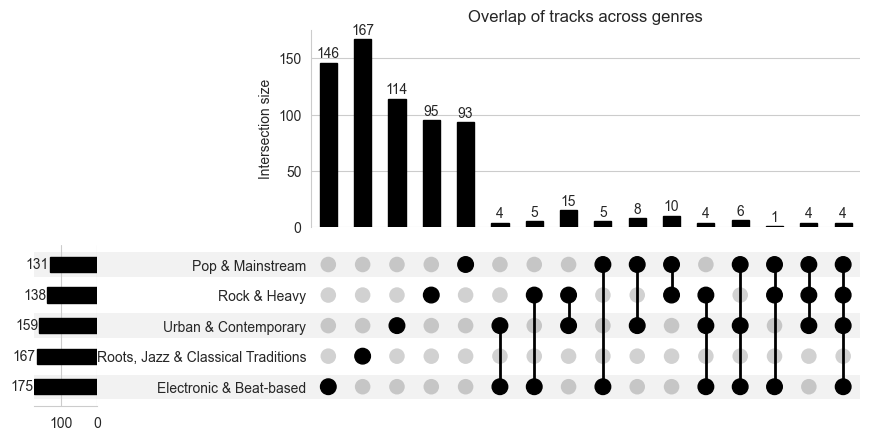

In [153]:
from upsetplot import from_contents, plot
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarnings from upsetplot library
warnings.filterwarnings('ignore', category=FutureWarning)

# Source - https://stackoverflow.com/a
# Posted by astrofrog, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-28, License - CC BY-SA 4.0


genre_data = {
    'Pop & Mainstream': df[df['first_genre'] == 1]['track_id'].unique(),
    'Urban & Contemporary': df[df['first_genre'] == 2]['track_id'].unique(),
    'Electronic & Beat-based': df[df['first_genre'] == 3]['track_id'].unique(),
    'Rock & Heavy': df[df['first_genre'] == 4]['track_id'].unique(),
    'Roots, Jazz & Classical Traditions': df[df['first_genre'] == 5]['track_id'].unique()
}

upset_data = from_contents(genre_data)

plot(upset_data, subset_size='count', show_counts=True)
plt.title("Overlap of tracks across genres")
plt.show()


## Note : Total Partitions : Sterling number of 2nd Kind
# Left Bottom : Songs per Genre (repitition is allowed)
# Dots alone : Set containg elements belongs to them alone
# Segments : Interactions of the sets
# The empty intersections are not plotted.

# Ref : 
# https://vdl.sci.utah.edu/publications/2014_infovis_upset/

In [ ]:
# Overlap percent
print('Percentage of overlapped tracks in each first_genre:')
print(f'Rock & Heavy: {round(100*(1-(95/138)),2)}%')
print(f'Pop & Mainstream: {round(100*(1-(93/131)),2)}%')
print(f'Urban & Contemporary: {round(100*(1-(114/159)),2)}%')
print(f'Electronic & Beat-based: {round(100*(1-(146/175)),2)}%')
print(f'Roots, Jazz & Classical Traditions: {round(100*(1-(167/167)),2)}%')


Percentage of overlapped tracks in each first_genre:
Rock & Heavy: 31.16%
Pop & Mainstream: 29.01%
Urban & Contemporary: 28.3%
Electronic & Beat-based: 16.57%
Roots, Jazz & Classical Traditions: 0.0%


## Genre Purity Analysis

| Genre | Total Unique Tracks | Exclusive Tracks | Purity Ratio |
|-------|-------------------|------------------|--------------|
| Pop & Mainstream | 131 | 93 | 71.0% |
| Urban & Contemporary | 159 | 114 | 71.7% |
| Electronic & Beat-based | 175 | 146 | 83.4% |
| Rock & Heavy | 138 | 95 | 68.8% |
| Roots, Jazz & Classical | 167 | 167 | **100.0%** |

**Average purity: 78.98%** (21.02% genre contamination)



## Build tracks dataframe which contains all unique tracks 
### Tracks which have overlap, i.e., those tracks which appear in multiple differently seeded playlists will be assigned the lowest occuring values of first_genre and position

In [163]:
# Remove categorical features like key and mode before plotting
features = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# Preserve seed tracks
seed_tracks = df[df['position'] < 2][['track_id','track_name', 'position', 'genre_label', 'first_genre']].drop_duplicates().sort_values(['first_genre', 'position']).reset_index(drop=True)
seed_ids = seed_tracks['track_id'].tolist()

tracks = df[['track_id', 'position', 'first_genre', 'track_name'] + features].drop_duplicates()

# Separate dataframe for seed tracks and others
tracks_seeds = tracks[tracks['track_id'].isin(seed_ids) & (tracks['position'] < 2)]
tracks_others = tracks[~tracks['track_id'].isin(seed_ids)]

agg_logic = {col: 'first' for col in features + ['track_name']}
agg_logic.update({'position': 'min', 'first_genre': 'min'})

# Combine other tracks such that the lowest first_genre and position is preserved
tracks_others_agg = tracks_others.groupby('track_id', as_index=False).agg(agg_logic)

# Final tracks = seeds + others (with preserved first_genre and position)
tracks = pd.concat([tracks_seeds, tracks_others_agg], ignore_index=True)

genre_mapping = {
    1: '1. Pop & Mainstream',
    2: '2. Urban & Contemporary',
    3: '3. Electronic & Beat-Based',
    4: '4. Rock & Heavy',
    5: '5. Roots, Jazz & Classical Traditions'
}

genre_color = {
    '1. Pop & Mainstream': '#1DB954',           # Spotify Green
    '2. Urban & Contemporary': '#9146FF',      # Twitch/Urban Purple
    '3. Electronic & Beat-Based': '#FF0050',   # High-energy Neon Red/Pink
    '4. Rock & Heavy': "#00E1FF",              # Dark Grey/Black
    '5. Roots, Jazz & Classical Traditions': '#FF9100' # Warm Orange/Amber
}

tracks['genre'] = tracks['first_genre'].map(genre_mapping)

tracks.head()

,track_id,position,first_genre,track_name,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre
0,7p6oXzBSPAXXz8Xb8gBPki,0,3,Subzero - Original Mix,-1.896625,0.690251,1.104661,0.140809,1.907263,-0.526567,-0.263274,-0.104692,0.083188,-1.328129,3. Electronic & Beat-Based
1,4uUG5RXrOk84mYEfFvj3cK,1,3,I'm Good (Blue),0.725136,-0.881374,-0.101550,1.438760,-0.528461,1.518397,0.694964,-0.611020,0.185142,-0.576272,3. Electronic & Beat-Based
2,40gRh2ZURv5tYBo8yB9Lu3,0,5,"Piano Sonata No. 14 in C-Sharp Minor, Op. 27 N...",-0.258024,1.682992,-1.234974,-1.538891,1.952527,-0.470912,-1.150532,-0.486740,-0.042318,-0.847102,"5. Roots, Jazz & Classical Traditions"
3,0G9qcE5Gz6xTz8jWXlRgBx,1,5,I've Got You Under My Skin - 2024 Remastered,-4.387297,1.300962,-0.023563,-1.178956,-0.528481,-0.361857,-0.470803,-0.578800,0.152839,0.838512,"5. Roots, Jazz & Classical Traditions"
4,3ENHpbTuY72FukZbwGP6bc,0,4,Tear Away,-0.454656,-0.890198,0.158409,0.286238,-0.520560,-0.635622,0.585966,-0.460656,0.350267,0.042191,4. Rock & Heavy


In [164]:
tracks.track_id.nunique()

681

## Assigned first-genres

In [166]:
tracks.groupby(['genre'])['track_id'].nunique()

genre
1. Pop & Mainstream                      131
2. Urban & Contemporary                  135
3. Electronic & Beat-Based               152
4. Rock & Heavy                           96
5. Roots, Jazz & Classical Traditions    167
Name: track_id, dtype: int64

## Initial first_genres

In [167]:
df.groupby(['genre_label'])['track_id'].nunique()

genre_label
Electronic & Beat-Based               175
Pop & Mainstream                      131
Rock & Heavy                          138
Roots, Jazz & Classical Traditions    167
Urban & Contemporary                  159
Name: track_id, dtype: int64

## PCA to visualize track features

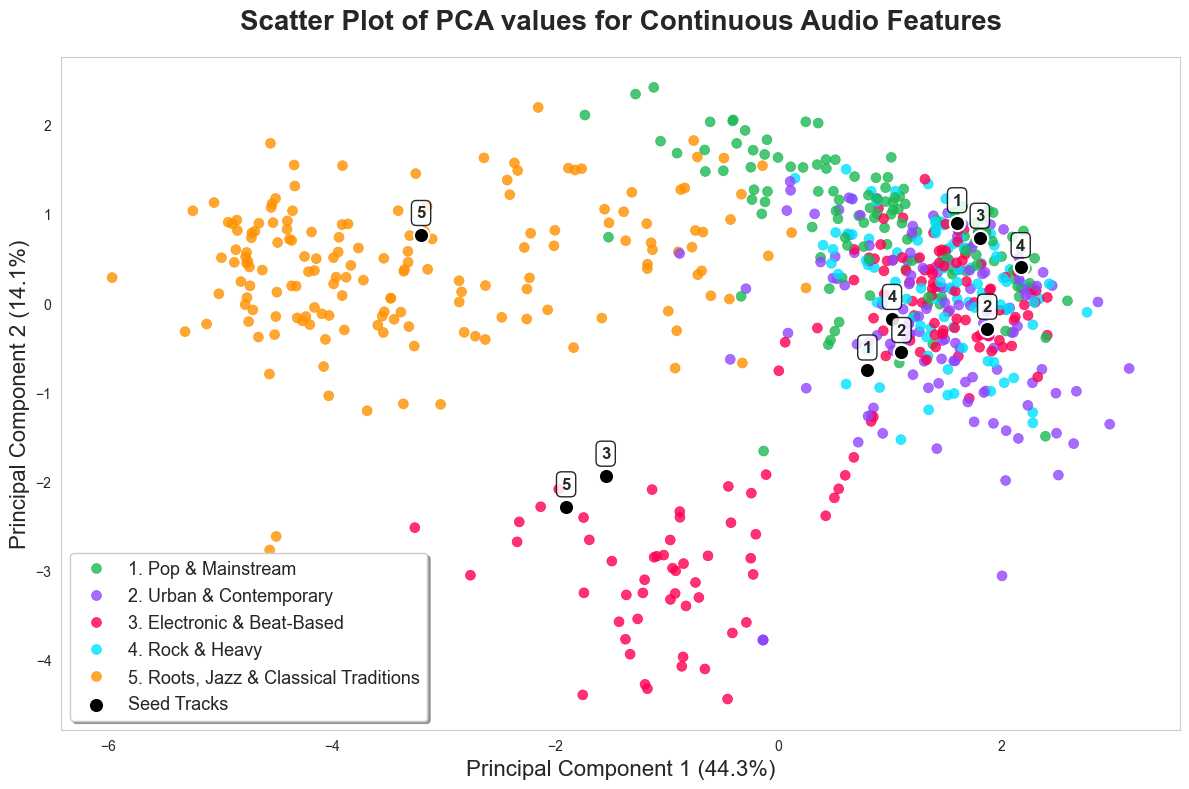

In [168]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize and fit PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(tracks[features])
tracks['pca-one'] = pca_results[:,0]
tracks['pca-two'] = pca_results[:,1]
exp_var = pca.explained_variance_ratio_

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# 2. Main Scatter Plot
ax = sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="genre",
    palette=genre_color,
    data=tracks,
    alpha=0.8,
    s=50,
    edgecolor=None
)

# 3. Overlay Seed Tracks
seeds_to_label = tracks[tracks['track_id'].isin(seed_tracks['track_id'])]

sns.scatterplot(
    x="pca-one", y="pca-two",
    data=seeds_to_label,
    color='black',
    s=120,         
    marker='o',   
    edgecolor='white',
    linewidth=1.5,
    label='Seed Tracks',
    zorder=5      
)

# 4. Enhanced Seed Labels
for i in range(len(seeds_to_label)):
    plt.text(
        x=seeds_to_label.iloc[i]['pca-one'],
        y=seeds_to_label.iloc[i]['pca-two'] + 0.2, # Adjust offset based on data scale
        s=seeds_to_label.iloc[i]['first_genre'], 
        fontsize=12,
        weight='bold',
        ha='center',
        bbox=dict(facecolor='white', alpha=0.85, edgecolor='black', boxstyle='round,pad=0.3'),
        zorder=10
    )

# 5. Formatting with Bigger Fonts
plt.title(f'Scatter Plot of PCA values for Continuous Audio Features', 
          fontsize=20, pad=20, weight='bold')
plt.xlabel(f'Principal Component 1 ({exp_var[0]*100:.1f}%)', fontsize=16)
plt.ylabel(f'Principal Component 2 ({exp_var[1]*100:.1f}%)', fontsize=16)

# --- REARRANGE LEGEND ALPHABETICALLY ---
handles, labels = ax.get_legend_handles_labels()

# Sort both lists by the label name
sorted_legend = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_legend)

# Apply the sorted legend
plt.legend(
    sorted_handles, 
    sorted_labels, 
    loc='lower left', 
    fontsize=13, 
    frameon=True, 
    shadow=True, 
    title_fontsize=14
)

# sns.despine()
# plt.xlim(-7, 4)
# plt.ylim(-6, 3)
plt.grid(False)
plt.tight_layout()
plt.show()